# Assignment 2
Collaborators (Name, study id, github handle): <br />
August Hertz Bugge - s194350 - libze<br />
David Bro Ludvigsen - s204102 - davidAlvaBro<br />
Sebastian Nicolai Fabricius Grut  - s204150 - Sebastiannfg

Github : https://github.com/davidAlvaBro/comsocsci2023.git 

#### Contributions 
We collaborated as a group. We have had weekly meetings where we completed the weekly assignments together - everything has been discussed and made together. 


#### Note
Sorry about the all the print statements, we try to keep it contained, but many of the assignments (especially part 4) has long and tedious print statements we could not get around. To escape them one can open and close sections of the notebook. Good luck and have fun.

In [1]:
# Imports that will be used through the notebook
import networkx as nx
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import netwulf
import copy
import community

DATA_PATH = "my_data/"

## 1 Mixing Patterns and Assortativity

### For each node, compute the fraction of edges that connect to a node that works in the same top field. Find the average value across all nodes.

In [2]:
# Load the graph from week 4
CSS_graph = nx.read_graphml(DATA_PATH + 'CSS_graph.graphml')

# Only work on the largest connected component
CSS_graph_cc = sorted(nx.connected_components(CSS_graph), key=len, reverse=True)
CSS_giant = CSS_graph.subgraph(CSS_graph_cc[0])

# Save the giant component
nx.write_graphml(CSS_giant, DATA_PATH + 'CSS_giant.graphml')


In [3]:
# Function to calculate the fraction of neighbors that have the same attribute value
def get_matching_att(graph, att):
    """
    A function that calculates the fraction of neighbors that have the same attribute value
    
    Args:
        graph (nx.Graph): The graph to be analyzed
        att (str): The attribute to be analyzed
    
    Returns:
        match_frac (dict): A dictionary with the fraction of neighbors that have the same attribute value
    """
    match_frac = {}
    for node in graph.nodes:
        counter = 0
        neighbors = len(list(graph.neighbors(node)))

        if neighbors == 0: match_frac[node] = 0 # Have to check this, otherwise devising by zero

        else:
            for neighbor in graph.neighbors(node):
                # Check if the attribute value is the same for the node and the neighbor
                if nx.get_node_attributes(graph, att)[neighbor] == nx.get_node_attributes(graph, att)[node]:
                    counter += 1

            match_frac[node] = counter / neighbors

    return match_frac


In [4]:
# Get the average fraction of neighbors that have the same attribute value 
top_field_fracs = get_matching_att(CSS_giant, 'att2')

print(f"Average across all nodes {np.mean(list(top_field_fracs.values()))}")

Average across all nodes 0.46120194367733425


### Create a new graph, with the same nodes and edges, but where the association between nodes and field is shuffled. Compute the measure above for this randomized graph.

In [5]:
# Function that shuffles the attribute values of a graph
def shuffle_node_att(graph, att):
    """ 
    A function that shuffles the attribute values of a graph
    
    Args:
        graph (nx.Graph): The graph to be analyzed
        att (str): The attribute to be analyzed
    
    Returns: 
        graph (nx.Graph): The graph with shuffled attributes
    """
    # Make dictionary with shuffled attributes
    shuffled_atts = nx.get_node_attributes(graph, att)
    temp = list(shuffled_atts.values())
    random.shuffle(temp)
    new_atts = dict(zip(shuffled_atts, temp))

    # Set the shuffled attributes
    nx.set_node_attributes(graph, new_atts, att)
    
    return graph


In [6]:
# Make a copy of the graph and shuffle the attribute values
CSS_giant_copy = copy.deepcopy(CSS_giant)
CSS_giant_copy = shuffle_node_att(CSS_giant_copy, 'att2')

print(f"When the fields are randomly assigned, on average an auther has {np.mean(list(get_matching_att(CSS_giant_copy, 'att2').values()))} of their neighbors in the same field")


When the fields are randomly assigned, on average an auther has 0.3065193323243449 of their neighbors in the same field


### Repeat the point above 100 times (at least). Plot the distribution of the values obtained and compare it with the value you have found for the real graph. Is the chance to connect to a member of the same field significantly higher than it would be by chance?

In [7]:
try: 
    distribution = np.load(DATA_PATH + "avg_same_field_distribution.npy")
except: 
    # Shuffles the graph attributes N times and stores the distribution of the average fraction of neighbors that have the same attribute value
    N = 300
    distribution = np.zeros(N)
    for i in tqdm(range(N)):
        CSS_giant_copy = shuffle_node_att(CSS_giant_copy, 'att2')
        avg = np.mean(list(get_matching_att(CSS_giant_copy, 'att2').values()))
        distribution[i] = avg 

    np.save(DATA_PATH + "avg_same_field_distribution.npy", distribution)

In [8]:
# Load the distribution if not in memory 
if 'distribution' not in locals():
    distribution = np.load(DATA_PATH + "avg_same_field_distribution.npy")

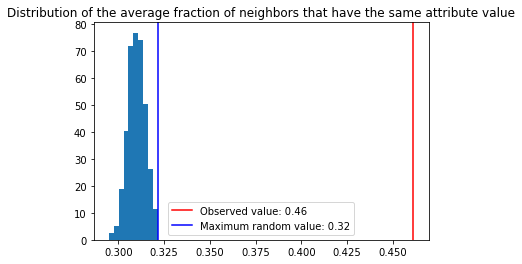

In [9]:
# Setup for plot
bins = 10
avg_value = np.mean(list(top_field_fracs.values()))

# Plot the distribution
figure, ax = plt.subplots(1)

ax.hist(distribution, density=True, bins=bins)
ax.axvline(x=avg_value, color='r', label=f"Observed value: {avg_value:.2f}")
ax.axvline(x=np.max(distribution), color='b', label=f"Maximum random value: {np.max(distribution):.2f}")
ax.legend()
ax.title.set_text("Distribution of the average fraction of neighbors that have the same attribute value")

plt.show()

In the plot we see the distribution of the average fraction of coauthers of the same field each author has. The red line indicates our observed dataset as one datapoint, while the blue line indicates the largest value in the randomly generated datasets. 

We see that the observed average fraction of authors with the same field as the author in question is 0.46, but nothing close to this value has ever occured in the randomly generated data with 300 samples, this implies that the distribution of it stems from is significantly different than the randomly generated distribution. This is seen in the plot by the largest random value (the blue vertical line) being smaller than the observed value (the blue vertical line). 

In other words, authors tend to work together with authors of the same field. 

### Compute the assortativity coefficient with respect to author's field. How do you interpret the value you obtain?

We use the formula stated; 
$$r = \frac{Tr(e) - ||e^2||}{1 - ||e^2||}.$$

First we compute $e$, that is we count each edge (twice) that goes from each author group to another to set up the matrix. Next we compute the trace, and at last we square the matrix and sum it. 

In [10]:
# This method generates the matrix used to calculate the association for a given attribute. 
# It is correosponding to the function attribute_mixing_matrix in the networkx package
def get_mixing_matrix(graph, att):
    """
    A function that calculates the matrix of the fraction of edges between fields.
    Assumes that the graph is undirected.
    
    Args:
        graph (nx.Graph): The graph to be analyzed
        att (str): The attribute to be analyzed
    
    Returns:
        E (np.array): The matrix of the fraction of edges between fields
        list_of_fields (dict): A dictionary with the fields as keys and the index of the field in the matrix as values
    """
    # Get dimensions of matrix
    list_of_fields = {field: i for i, field in enumerate(set(nx.get_node_attributes(graph, att).values()))}
    E = np.zeros((len(list_of_fields), len(list_of_fields)))

    # Fill the matrix/dictionary
    for edge in tqdm(graph.edges):
        # Get the field of the node at the ends of the edge 
        node_1_field = nx.get_node_attributes(graph, att)[edge[0]]
        node_2_field = nx.get_node_attributes(graph, att)[edge[1]]
        # To make the matrix symetric, we add the value to both fields
        E[list_of_fields[node_1_field], list_of_fields[node_2_field]] += 1
        E[list_of_fields[node_2_field], list_of_fields[node_1_field]] += 1
    
    E = E / (2*graph.number_of_edges())

    return E, list_of_fields


In [11]:
# Check if it works
mixing_matrix, _ = get_mixing_matrix(CSS_giant, 'att2')
mixing_matrix_2 = nx.attribute_mixing_matrix(CSS_giant, 'att2')

# Only certain checks 
print(np.trace(mixing_matrix), np.sum(mixing_matrix))
print(np.trace(mixing_matrix_2), np.sum(mixing_matrix_2)) 

100%|██████████| 13045/13045 [03:04<00:00, 70.77it/s]


0.46155615178229203 1.0
0.46155615178229203 1.0


In [12]:
# Calculate the association for fields
calculate_assortiative_coef = lambda E: (np.trace(E) - np.sum(E @ E.T)) / (1 - np.sum(E @ E.T))
print(f"The association for fields is {calculate_assortiative_coef(mixing_matrix):.2f}")
print(f"The association for fields is {nx.attribute_assortativity_coefficient(CSS_giant, 'att2'):.2f}, calculated with the mx library")

The association for fields is 0.17
The association for fields is 0.17, calculated with the mx library


### Is the graph assortative with respect to the degree?

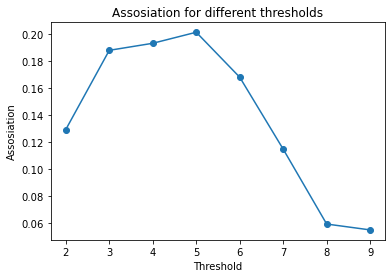

In [13]:
# Very similar to the function above, but this calculates the matrix for the degree instead of attribute
get_i = lambda x, threshold: 1 if x > threshold else 0 # Small function to get the index of the matrix

max_threshold = 10
assosiations = np.zeros(max_threshold - 2)

for threshold in range(2, max_threshold):
    # Get dimensions of matrix
    E = np.zeros((2, 2))

    # Fill the matrix
    for edge in CSS_giant.edges:
        # Get the degree of the node at the ends of the edge
        i = get_i(CSS_giant.degree(edge[0]), threshold)
        j = get_i(CSS_giant.degree(edge[1]), threshold)
        E[i, j] += 1
        E[j, i] += 1

    E = E / (2*CSS_giant.number_of_edges())
    
    # Store the assosiation
    assosiations[threshold - 2] = calculate_assortiative_coef(E)

plt.plot(range(2, max_threshold), assosiations, "-o")
plt.xlabel("Threshold")
plt.ylabel("Assosiation")
plt.title("Assosiation for different thresholds")
plt.show()

From this graph we can see that there is an assosiation when the "high degrees" are relatively small numbers, but the assosiation becomes negliable when "high degress" are large (above 8). 

When we created the dataset we started with an amount of authors and looked at all of their papers. These original authors will have many coauthors because the "spawned" the rest of the dataset. This introduces some noise in who has a high degree. 

#### TODO expand on this 

## Communities - Exercise 2, Zachary's karate club 

### Visualize the graph using netwulf. Set the color of each node based on the club split.

In [14]:
# Load the graph
karclub_data = nx.karate_club_graph()
club_membership = nx.get_node_attributes(karclub_data, "club")

#setting the colors of different club nodes
colors = {}
clubs = []#For use later
mrhi_members = []
officer_members = []

for node in range(len(karclub_data.nodes)):
    if club_membership[node] == 'Mr. Hi': 
        colors[node] = "blue"
        mrhi_members.append(node)
    else:
        colors[node] = "red"
        officer_members.append(node)

clubs.append(mrhi_members)
clubs.append(officer_members)
nx.set_node_attributes(karclub_data,colors,"color")

# Visualize the graph with netwulf 
# netwulf.interactive.visualize(karclub_data,config={"Node color": "color"})

![Alt text](my_data/karate_club.png)

### Write a function to compute the modularity of a graph partitioning (use equation 9.12 in the book). The function should take a networkX Graph and a partitioning as inputs and return the modularity.

This is done with the formula (9.12) from the book, 
$$M = \sum_{c=1}^{n_c} \left[\frac{L_c}{L} - \left(\frac{k_c}{2L}\right)^2\right]. $$

In [15]:
#Modularity function
def modularity(G, communities):
    """
    Compute the modularity for a communities of a graph.

    Parameters:
        - G: the NetworkX graph
        - communities (list): a list of communities, where each community is a list of node IDs

    Returns:
        - M: the modularity value for the graph
    """
    
    total_links = G.number_of_edges()
    num_of_communities = len(communities)
    links_in_community = {community: 0 for community in range(num_of_communities)}
    tot_degree = {community: 0 for community in range(num_of_communities)}
    
    # Dictionary to map node IDs to community IDs
    communities_lookup = {node: community for community, nodes in enumerate(communities) for node in nodes}

    # Count the number of links within each community and the total degree of each community
    for (node_1, node_2) in G.edges():
        node_1_community = communities_lookup[node_1]
        node_2_community = communities_lookup[node_2]
        
        # Since we go through all edges, we also get the degree of all nodes
        tot_degree[node_1_community] += 1
        tot_degree[node_2_community] += 1
        
        # If the nodes are in the same community, add one to that community's link count
        if node_1_community == node_2_community:
            links_in_community[node_1_community] += 1

    # Compute the modularity
    M = 0.0
    for i in range(num_of_communities):
        M += (links_in_community[i] / total_links) - ((tot_degree[i] / (2 * total_links)) ** 2)

    return M


### Explain in your own words the concept of modularity

The formula to calculate the modularity is, as stated, given by, 
$M = \sum_{c=1}^{n_c} \left[\frac{L_c}{L} - \left(\frac{k_c}{2L}\right)^2\right]$,  and it tells us the degree in which the network is modular, given a partition into communities. 

It measures the difference between the number of edges within each community, and the expected number of edges given a random distribution. The value, $M \in [-1, 1]$, where positive values express that the communities have more links within them, then they would at random, while negative values show the opposite. 

If it is close to one, we likely have a dense community structure and the partition is close to having found these communities. If it is close to 0, we perhaps have a more homogenous structure without any clear structure, or we have a partition that does not reflect the true communities. At last values close to -1 tells us that the partition used have divided the graph poorly into communities, and that a random distribution would form stronger communities with this partition. 

Modularity is a useful metric in the analysis of complex networks for this reason.

### Compute the modularity of the Karate club split partitioning using the function you just wrote.

In [16]:
kar_club_modularity = modularity(karclub_data, clubs)
print(f"The modularity of the karate club graph is {kar_club_modularity:.2f}")

The modularity of the karate club graph is 0.36


### Implementation of the double edge swap algorithm 

In [17]:
#Random Edge swap function

def edge_swap(G, N):
    """
    create a copy of G with N swapped edges

    Parameters:
        - G: the given graph
        - N: how many edges we want swapped

    Returns:
        - G_copy: a copy of graph g with N edges swapped at random
    """
    
    # Make a copy of the original network, to not change the original
    G = copy.deepcopy(G)
    
    # Perform at least N edge swaps
    edges_swapped = 0
    while edges_swapped <= N:
        # Choose two random edges
        edges = random.sample(G.edges(), 2)
        (u, v) = edges[0]
        (x, y) = edges[1]
        # Check that we will not link a node to itself
        # We believe that there was an error in the instructions
        # That it is not meant to say u != v, as this is trivial and can't happen
        # Instead it is vital to check that u != y such that we don't link u to itself
        if u != y and v != x:
            # Check if the edges (u,y) and (x,v) exist
            if not G.has_edge(u, y) and not G.has_edge(x, v):
                # Swap the edges 
                G.remove_edge(u, v)
                G.remove_edge(x, y)
                G.add_edge(u, y)
                G.add_edge(x, v)

                #Counter for number of swaps
                edges_swapped += 1

    return G

### Double check that your algorithm works well, by showing that the degree of nodes in the original network and the new 'randomized' version of the network are the same.

In [18]:
#looping to see if every node has the same degree

karclub_random = edge_swap(karclub_data, 100)

for i in karclub_data.nodes():
    #If the loop does not return anything, all the degrees are the same
    
    if karclub_data.degree(i) == karclub_random.degree[i]:
        pass
    else:
        print("There is a node with a different degree!")
        

C:\Users\david\AppData\Local\Temp/ipykernel_7628/4256096761.py:22: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  edges = random.sample(G.edges(), 2)


### Create 1000 randomized version of the Karate Club network using the double edge swap algorithm you wrote in step 5. For each of them, compute the modularity of the "club" split and store it in a list.

In [19]:
# Set seed in the interest of repeatability
random.seed(69420)
# A list that will contain a thousand randomized modularities
rand_modularities = np.zeros((1000))

#The loop that produces a thousand edge swapped datasets, and appends them to rand_modularities
#Here we use the previously defined modularity and edge_swap funtions
for i in tqdm(range(1000)):
    rand_karclub = edge_swap(karclub_data, 100)
    rand_modularities[i] = (modularity(rand_karclub, clubs))


  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\david\AppData\Local\Temp/ipykernel_7628/4256096761.py:22: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  edges = random.sample(G.edges(), 2)
100%|██████████| 1000/1000 [00:09<00:00, 110.79it/s]


### Compute the average and standard deviation of the modularity for the random network.

In [20]:
mean_rand_mods = np.mean(rand_modularities)
std_rand_mods = np.std(rand_modularities)

print("The mean of the thousand edge swapped modularities is " + str(mean_rand_mods))
print("The standard deviation of the thousand edge swapped modularities is " + str(std_rand_mods))

The mean of the thousand edge swapped modularities is -0.08986785009861939
The standard deviation of the thousand edge swapped modularities is 0.04363062939232349


### Plot the distribution of the "random" modularity. Plot the actual modularity of the club split as a vertical line (use axvline).

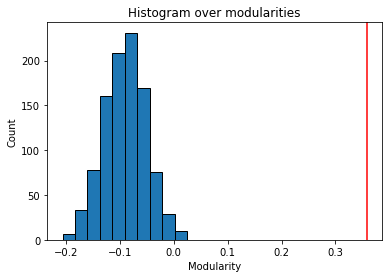

In [21]:
# Plotting a histogram over the distribution values for

plt.hist(rand_modularities, edgecolor='black')
plt.xlabel('Modularity')
plt.ylabel('Count')
plt.title('Histogram over modularities')
plt.axvline(x=kar_club_modularity, color = "red")
plt.show()

### Comment on the figure. Is the club split a good partitioning? Why do you think I asked you to perform a randomization experiment? What is the reason why we preserved the nodes degree?

As we can see, the karate club dataset partitioning is significantly different from the random modularities generated by the randomization experiment, which tells us that we have a good partitioning. 

The point of prserving the nodes degree is to ensure any change was due to a difference in edge distribution, rather than a change in the structure of the network. Changing the degree distribution can significantly change the structure of the network. However, if we simply move some edges around while preserving the degree distribution, we ensure the change is not due to a change in the degree distribution. The point of the randomization experiment is to test the modularity of the network, to see if it is significantly different from what we would see if the edges we're formed at random, given the same degree distribution.

#### TODO check this 

### Use the Python Louvain-algorithm implementation to find communities in this graph. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the club split? What does this comparison reveal?

In [22]:
# Function that applies the Louvain algorithm to a grap, and returns communities
def louvain_communities(graph):
    # Use the louvain method to find communities
    partition = community.best_partition(graph) # community function that uses Louvain-algorithm
    
    # Reformat the partitioning
    communities = {}
    for node, community_id in partition.items():
        if community_id in communities:
            communities[community_id].append(node)
        else:
            communities[community_id] = [node]
    
    return list(communities.values())

In [23]:
# Get the communities using the Louvain algorithm and calculate the modularity
karclub_louvain_groups = louvain_communities(karclub_data)
print(f"The modularity of the karate club graph using the Louvain algorithm is {modularity(karclub_data, karclub_louvain_groups):.2f}")

The modularity of the karate club graph using the Louvain algorithm is 0.42


### Get the confusion matrix from the two partitions into communities (Original vs Louvain)

In [24]:
def confusion_matrix(community1, community2):
    """
    Creates an unweighted confusion matrix comparing two sets of communities.

    Args:
    - community1: a list of lists, where each inner list contains the nodes in a community
    - community2: a list of lists, where each inner list contains the nodes in a community

    Returns:
    - confusion_matrix: a 2D list representing the confusion matrix
    """

    # Get the number of communities in each list
    n1 = len(community1)
    n2 = len(community2)

    # Create an empty confusion matrix with n1 rows and n2 columns
    confusion_matrix = np.zeros((n1, n2)) #  [[0] * n2 for _ in range(n1)]

    # Loop over each community in community1
    for i, c1 in enumerate(community1):
        # Loop over each community in community2
        for j, c2 in enumerate(community2):
            # Count the number of nodes in common between the two communities
            common_nodes = len(set(c1) & set(c2))
            # Add the count to the confusion matrix
            confusion_matrix[i, j] = common_nodes

    return confusion_matrix

In [25]:
print(confusion_matrix(clubs, karclub_louvain_groups))

[[11.  5.  1.  0.]
 [ 1.  0. 10.  6.]]


It would seem that Louvain followed almost the same distribution as clubs, however, it split the two clubs further into two subgroups each.

Only one member has been moved into a new community, that member was moved from the first community in the original partitioning to the third community in the new partitioning. In the third community of the new partitioning all 11 other members are from the second community in the original partitioning. 

Besides that it is impressive that the Louvain algorithm finds this partition so effortlessly. 

#### TODO look at this again, this might not be deterministic because it has changed!?

## Communities - Exercise 3, CSS
We still work on the giant component in this section, as it does not really make sense to look at the communities of individuals that are not linked to any other or few others. 

### Use the Python Louvain-algorithm implementation to find communities. How many communities do you find? What are their sizes? Report the value of modularity found by the algorithm. Is the modularity significantly different than 0?

In [26]:
# Finding the communities in the giant component with the Louvain algorithm
CSS_louvain_groups = louvain_communities(CSS_giant)

# Compute the modulary of the giant component, with the Louvain communities
CSS_modularity = modularity(CSS_giant, CSS_louvain_groups)

print("The modularity of the CSS graph is " + str(CSS_modularity))
print("There are " + str(len(CSS_louvain_groups)) + " communities")

# Save the list of communities to a file
np.save(DATA_PATH + 'CSS_louvain_groups.npy', CSS_louvain_groups)


The modularity of the CSS graph is 0.868655846929012
There are 66 communities


c:\Users\david\Anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


 -- Below is a histogram of the sizes of the communities -- 


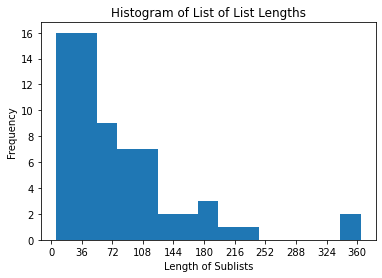

In [27]:
# Plot the distribution of community sizes
print(" -- Below is a histogram of the sizes of the communities -- ")
community_sizes = [len(sublist) for sublist in CSS_louvain_groups]
plt.hist(community_sizes, bins = 15)
plt.xlabel('Length of Sublists')
plt.ylabel('Frequency')
plt.xticks(range(0, max(community_sizes)+1, (max(community_sizes)) // 10))
plt.title('Histogram of List of List Lengths')
plt.show()

We can see that the modularity of this partition of communities is very close to 1, which tells us that it is very likely that it is significantly above 0. However, it may still be worth doing a 1000 fold randomization of models as we did before.

In [29]:
try: 
    rand_modularities_2 = np.load(DATA_PATH + "rand_modularities_2.npy", allow_pickle=True)
except: 
    #Set seed in the interest of repeatability
    random.seed(69420)
    #A list that will contain a thousand randomized modularities
    rand_modularities_2 = []

    # Load the louvain groups if not in memory 
    if 'CSS_louvain_groups' not in locals():
        CSS_louvain_groups = np.load(DATA_PATH + "CSS_louvian_groups.npy", allow_pickle=True)

    #The loop that produces a thousand edge swapped datasets, and appends them to rand_modularities
    #Here we use the previously defined modularity and edge_swap funtions
    giant_unfrozen = nx.Graph(CSS_giant)
    for i in tqdm(range(10)):
        rand_giant = edge_swap(giant_unfrozen, 13046)
        rand_modularities_2.append(modularity(rand_giant, CSS_louvain_groups))

    # Save the date 
    np.save(DATA_PATH + "rand_modularities_2.npy", rand_modularities_2)

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\david\AppData\Local\Temp/ipykernel_7628/4256096761.py:22: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  edges = random.sample(G.edges(), 2)
  0%|          | 0/10 [00:03<?, ?it/s]


KeyboardInterrupt: 

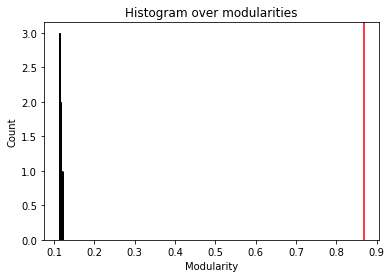

In [89]:
# Plotting a histogram over the distribution of modularities for the edge swapped giant component

plt.hist(rand_modularities_2, edgecolor='black')
plt.xlabel('Modularity')
plt.ylabel('Count')
plt.title('Histogram over modularities')
plt.axvline(x=CSS_modularity, color = "red")
plt.show()

### Visualize the network, using netwulf (see Week 5). This time assign each node a different color based on their community. Describe the structure you observe.

In [30]:
#Removing the year attribute because a few papers have undefined years 
for n, attrs in CSS_giant.nodes(data=True):
    attrs.pop('att5', None)

In [31]:
import matplotlib.colors as mcolors
# List of colors to use for the visualization
colors = list(mcolors.CSS4_COLORS.values())[:len(CSS_louvain_groups)]

# Use netwulf to visualize the communities
def visualize_communities(graph, communities):
    # Create a dictionary that maps nodes to communities
    node_to_community = {}
    for i, community in enumerate(communities):
        for node in community:
            node_to_community[node] = i
      
    # Add a color attribute to the nodes
    for node in graph.nodes:
        # Add the community number as a node attribute
        graph.nodes[node]["color"] = colors[node_to_community[node]] 

    # Visualize the graph with netwulf
    netwulf.visualize(graph, config={"Node color": "color"})
# netwulf.interactive.visualize(CSS_giant, config={"Node color": "color"})

# visualize_communities(CSS_giant, CSS_louvain_groups)

Visualization of the giant component with the communties found with the Lovian algorithm; 


#### TODO interpret the results here! 

![Alt text](my_data/CSS_network.png)

## Exercise 4: TF-IDF and the Computational Social Science communities.

### First, check out the wikipedia page for TF-IDF. Explain in your own words the point of TF-IDF.
We think wikipedia explains well the point of TF-IDF in one sentence; 
TF-IDF is a numerical statistic that is intended to reflect how important a word is to a document in a corpus of documents (slight alterations are made in this quote as it is taken out of context). 

TF-IDF is the amount of times the word appears in the document, divided with how many documents contain the word in the corpus. Now this scalar can be used to compare different words in the document to see which more uniquely define the document. If we did not multiply with the inverse document frequency, commen words would dominate the TF weighting, and it would not be very effective at classifying the most important words for a text. 

##### TODOD remove this? 
One has to be carefull about how one interprets the TF-IDF of a word, and one should not compare values between documents, because TF is artificially inflated if the text is longer. One shouldn't compare TF-IDF values between different corpuses, because it becomes artificially smaller when the corpus is larger. 

#### What does TF stand for?
Term Frequency (how many times a term/token appears in a document)
#### What does IDF stand for? 
Inverse Document Frequency (one divided by how many documents in the corpus that includes the term/token)


### Create large documents for each community. Each document includes all the tokens of abstracts written by members of a given community.

In [32]:
# imports for the text analysis
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import ast

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
# Load the paper abstracts
df_abstract = pd.read_csv(DATA_PATH + 'df_CSS_paper_abstract.csv')

In [35]:
# Function to clean strings
def clean_strings(strings):
    """ Cleans a list of strings by removing URLs, numbers, punctuation and stop words
    
    Args:
    - strings: a list of strings
    
    returns:
    - cleaned_strings: a list of cleaned strings
    """
    cleaned_strings = []
    stop_words = set(stopwords.words('english'))

    for string in strings:
        # Remove URLs
        string = re.sub(r'http\S+', '', string)

        # Remove numbers
        string = re.sub(r'[0-9]', '', string)

        # Keep only what is not punctuation
        string = re.sub(r'[^\w\s]', '', string)

        # Remove stop words and moke them
        if string not in stop_words: string = string.lower()

        # Remove empty strings
        if len(string):
            cleaned_strings.append(string)

    return cleaned_strings

# If the dataframe has not yet gotten the tokens (from week 7), do it here and save it
if not 'tokens' in df_abstract.columns:
    cleaned_corpus = []
    df_abstract['tokens'] = None
    for i, row in tqdm(df_abstract.iterrows()):
        abstract = row['abstract']
        if type(abstract) == str:

            tokens = nltk.word_tokenize(row['abstract'])
            clean_tokens = clean_strings(tokens)
            cleaned_corpus.append(clean_tokens)
            df_abstract['tokens'][i] = clean_tokens
        else:
            cleaned_corpus.append(None)
    df_abstract.to_csv('my_data/df_CSS_paper_abstract.csv')


In [36]:
# Load data if it is not in memory yet
if 'CSS_louvain_groups' not in locals():
    CSS_louvain_groups = np.load(DATA_PATH + 'CSS_louvain_groups.npy', allow_pickle=True)
if 'CSS_giant' not in locals():
    CSS_giant = nx.read_graphml(DATA_PATH + 'CSS_giant.graphml')


In [37]:
# Load the tokens of the community documents if they are already saved
try: 
    community_documents = np.load(DATA_PATH + 'community_documents.npy', allow_pickle=True)
except: 
    # Create a document for each community that contains the combined abstracts of all papers in that community
    community_documents = [[] for _ in range(len(CSS_louvain_groups))]

    # Create a dictionary that maps nodes to communities
    node_to_community = {}
    for i, community in enumerate(CSS_louvain_groups):
        for node in community:
            node_to_community[node] = i

    # Loop over all papers
    for i, paper in tqdm(df_abstract.iterrows()):
        # We need the authors and the tokens 
        if type(paper['authors']) == str:
            authors = ast.literal_eval(paper['authors'])
        if type(paper['tokens']) == str:
            # Only take unique tokens, because otherwise one paper can use one token many times and control the average
            tokens = list(set(ast.literal_eval(paper['tokens'])))
            tokens = ast.literal_eval(paper['tokens'])
        
        # Loop over all authors of the paper
        for author in authors:
        # If the author is in the giant component, add the tokens to the community document
            if author in CSS_giant.nodes:
                community_documents[node_to_community[author]] += tokens

    # Save the community documents to a file
    np.save(DATA_PATH + 'community_documents.npy', community_documents)


In [38]:
# Calculate the tf scores for each community

def TF_from_corpus(corpus):
    """ Calculates the TF scores for each word in the corpus

    Args:
        corpus (list): list of lists of words/strings

    Returns:
        TF_df (pandas.DataFrame): Dataframe containing the TF scores for each word in the corpus
    """
    # Create empty dictionary to keep track of word counts
    word_counts = {}
    n_communities = len(corpus) 
    
    # Iterate through all communities
    for i, document in tqdm(enumerate(corpus)):
        # Iterate through each word in the current sublist
        for word in document:
            # If the current word is not in the dictionary, add it with a list of zeros
            if word not in word_counts:
                word_counts[word] = [0] * n_communities
            
            # Increment count for the current word and list index
            word_counts[word][i] += 1
    
    # Create pandas dataframe from the word_counts dictionary
    TF_df = pd.DataFrame.from_dict(word_counts).transpose()
    
    return TF_df


In [39]:
# Calculate the tf scores for each community
try:
    TF_df = pd.read_csv(DATA_PATH + 'TF_df.csv', allow_pickle=True)
except:
    TF_df = TF_from_corpus(community_documents)
    TF_df.to_csv(DATA_PATH + 'TF_df.csv')

68it [00:00, 94.95it/s]


In [40]:
# Get the five largest communities
idx_5_largest = np.argsort([-len(community) for community in CSS_louvain_groups])[:5]

for i, community in enumerate(idx_5_largest):
    print(f"{i+1}. largest community {community}: ")
    largest_5_words = TF_df[community].nlargest(5)
    for j in range(5):
        word = largest_5_words.index[j]
        count = largest_5_words.values[j]
        print(f"Word : {word}, count: {count}")


1. largest community 4: 
Word : the, count: 9367
Word : and, count: 8411
Word : of, count: 8281
Word : to, count: 5793
Word : in, count: 5049
2. largest community 3: 
Word : the, count: 989
Word : of, count: 654
Word : and, count: 566
Word : to, count: 416
Word : a, count: 382
3. largest community 8: 
Word : the, count: 1879
Word : of, count: 1244
Word : and, count: 876
Word : a, count: 726
Word : to, count: 707
4. largest community 1: 
Word : the, count: 7597
Word : of, count: 5229
Word : and, count: 2922
Word : a, count: 2800
Word : to, count: 2698
5. largest community 5: 
Word : the, count: 432
Word : and, count: 394
Word : of, count: 350
Word : to, count: 247
Word : in, count: 186


### Why aren't the TFs not necessarily a good description of the communities?
Because the most used words in all texts will be these common six words (the, of, and, to, in, a). Hence, it is not a good descriptor of the text. 

### Next, we calculate IDF for every word :

In [41]:
# Count number of times each word appears in the corpus
try:
    IDF_dict = np.load(DATA_PATH + 'IDF_dict.npy', allow_pickle=True).item()
except:
    base = 2 # log base
    count_of_occurence = TF_df.apply(lambda row: (row != 0).sum(), axis=1)
    IDF_dict = {word: np.emath.logn(base, len(TF_df.columns)/ count_of_occurence[word]) for word in TF_df.index}

    np.save(DATA_PATH + 'IDF_dict.npy', IDF_dict)


### We're ready to calculate TF-IDF. Do that for the top 9 communities (by number of authors)


In [42]:
def make_TF_IDF(TF_df, IDF_dict):
    """Multiply the TF and IDF scores to get the TF-IDF scores

    Args:
        TF_df (pandas.DataFrame): Dataframe containing the TF scores for each word in the corpus
        IDF_dict (dict): Dictionary containing the IDF scores for each word in the corpus

    Returns:
        TF_IDF (pandas.DataFrame): Dataframe containing the TF-IDF scores for each word in the corpus
    """
    TF_IDF = TF_df.copy()
    for word in tqdm(TF_IDF.index):
        TF_IDF.loc[word] = TF_IDF.loc[word] * IDF_dict[word]
        
    return TF_IDF

# Get the TF-IDF scores
try:
    TF_IDF = pd.read_csv(DATA_PATH + 'TF_IDF.csv', allow_pickle=True)
except: 
    TF_IDF = make_TF_IDF(TF_df, IDF_dict)
    # save this dataframe to a file
    TF_IDF.to_csv(DATA_PATH + 'TF_IDF.csv')   


100%|██████████| 36121/36121 [00:06<00:00, 5306.82it/s]


#### Comment on TF_IDF


After calculating our initial TF_IDF scores, we changed the way we find which tokens for each paper that goes into the document for the community, as seen below (we only count words once now), 
```python
tokens = ast.literal_eval(paper['tokens'])
tokens = list(set(ast.literal_eval(paper['tokens'])))
```
This is because words like "hn" and "rs" dorminated some of the top communities (by number of authors), persumably because one paper in that community mentions this token multiple times (in the case of "hn" 36 times). Below you can see the initial 5 largest communities largest 5 TF-IDF score words.


1. largest community 4: 

Word : vaping, count: 569.795838220038

Word : wikipedia, count: 379.6685493380867

Word : cscw, count: 379.2799191750436

Word : hci, count: 378.9442775281913

Word : workers, count: 227.00227019263153

2. largest community 0: 

Word : zikv, count: 706.1456895850395

Word : zika, count: 371.3352333162707

Word : vaccination, count: 284.6299611051854

Word : ihes, count: 244.19821638001633

Word : hn, count: 219.14866228501225

3. largest community 37: 

Word : auctions, count: 768.4307370733559

Word : auction, count: 724.9209844632578

Word : valuations, count: 685.916149102004

Word : bidders, count: 637.335173870169

Word : revenue, count: 536.0540849095265

4. largest community 1: 

Word : untrustworthy, count: 213.67343933251428

Word : gvcs, count: 213.0611994437619

Word : lockdown, count: 206.43575116101292

Word : banks, count: 199.8325452903814

Word : interbank, count: 183.80488390790572

5. largest community 11: 

Word : fgd, count: 219.14866228501225

Word : shapley, count: 195.1950265612763

Word : dicaprio, count: 182.6238852375102

Word : games, count: 172.7085862185866

Word : rs, count: 171.67343933251428


In [43]:
idx_9_largest = np.argsort([-len(community) for community in CSS_louvain_groups])[:9]
# Get the five largest communities
for i, community in enumerate(idx_9_largest):
    print(f"{i+1}. largest community {community}: ")
    largest_9_words = TF_IDF[community].nlargest(10)
    for j in range(10):
        word = largest_9_words.index[j]
        tf_idf = largest_9_words.values[j]
        # count = TF_df[community][word]
        # print(f"Word : {word}, TF: {count:.0f}, TF-IDF: {tf_idf:.0f}")
        print(f"Word : {word}, TF-IDF: {tf_idf:.0f}")
    print()

1. largest community 4: 
Word : vaping, TF-IDF: 570
Word : wikipedia, TF-IDF: 380
Word : cscw, TF-IDF: 379
Word : hci, TF-IDF: 379
Word : workers, TF-IDF: 227
Word : ips, TF-IDF: 213
Word : localness, TF-IDF: 207
Word : chi, TF-IDF: 199
Word : turkers, TF-IDF: 195
Word : cessation, TF-IDF: 195

2. largest community 3: 
Word : cheaters, TF-IDF: 488
Word : cheater, TF-IDF: 231
Word : cheating, TF-IDF: 225
Word : steam, TF-IDF: 153
Word : sinophobia, TF-IDF: 122
Word : gaming, TF-IDF: 119
Word : chan, TF-IDF: 119
Word : noncheaters, TF-IDF: 110
Word : gamers, TF-IDF: 109
Word : sinophobic, TF-IDF: 97

3. largest community 8: 
Word : earth, TF-IDF: 265
Word : anthropocene, TF-IDF: 170
Word : commuting, TF-IDF: 113
Word : esms, TF-IDF: 110
Word : planetary, TF-IDF: 98
Word : copan, TF-IDF: 91
Word : iams, TF-IDF: 91
Word : transmob, TF-IDF: 85
Word : modelers, TF-IDF: 81
Word : municipalities, TF-IDF: 79

4. largest community 1: 
Word : untrustworthy, TF-IDF: 214
Word : gvcs, TF-IDF: 213
Wo

In [44]:
# print the TF scores for the 9 largest communities
for i, community in enumerate(idx_9_largest):
    print(f"{i+1}. largest community {community}: ")
    largest_10_words = TF_df[community].nlargest(10)
    for j in range(10):
        word = largest_10_words.index[j]
        count = largest_10_words.values[j]
        print(f"Word : {word}, TF: {count}")
    print()

1. largest community 4: 
Word : the, TF: 9367
Word : and, TF: 8411
Word : of, TF: 8281
Word : to, TF: 5793
Word : in, TF: 5049
Word : a, TF: 4076
Word : we, TF: 3496
Word : that, TF: 2781
Word : for, TF: 2240
Word : on, TF: 1850

2. largest community 3: 
Word : the, TF: 989
Word : of, TF: 654
Word : and, TF: 566
Word : to, TF: 416
Word : a, TF: 382
Word : in, TF: 370
Word : we, TF: 298
Word : that, TF: 286
Word : is, TF: 223
Word : on, TF: 183

3. largest community 8: 
Word : the, TF: 1879
Word : of, TF: 1244
Word : and, TF: 876
Word : a, TF: 726
Word : to, TF: 707
Word : in, TF: 622
Word : we, TF: 418
Word : that, TF: 345
Word : for, TF: 286
Word : is, TF: 274

4. largest community 1: 
Word : the, TF: 7597
Word : of, TF: 5229
Word : and, TF: 2922
Word : a, TF: 2800
Word : to, TF: 2698
Word : in, TF: 2635
Word : we, TF: 2091
Word : that, TF: 1526
Word : is, TF: 1139
Word : on, TF: 1008

5. largest community 5: 
Word : the, TF: 432
Word : and, TF: 394
Word : of, TF: 350
Word : to, TF: 2

In [87]:
top_3_authers = {}
# Store the top 3 authors by degree for all communities
for i, community in enumerate(CSS_louvain_groups):
    # Get the top 3 authors by degree
    sorted_dict = sorted(dict(CSS_giant.degree(community)).items(), key=lambda x: x[1], reverse=True)
    names = nx.get_node_attributes(CSS_giant, "att1")
    top_3_keys = [k for k, v in sorted_dict[:3]] # Get the ID
    top_3_names = [names[k] for k in top_3_keys] # get the name 
    
    top_3_authers[i] = [(top_3_keys[j], top_3_names[j]) for j in range(len(top_3_keys))]
    
# Print the top 3 authors for the 9 largest communities
for i, community in enumerate(idx_9_largest):
    print(f"{i+1}. largest community {community}: ")
    for author in top_3_authers[community]:
        print(f"Author: {author[1]}, degree: {CSS_giant.degree(author[0])}")
    print()

1. largest community 4: 
Author: Brent J. Hecht, degree: 36
Author: A. Bruckman, degree: 33
Author: S. Schoenebeck, degree: 31

2. largest community 3: 
Author: Ingmar Weber, degree: 83
Author: M. Tizzoni, degree: 42
Author: D. Paolotti, degree: 40

3. largest community 8: 
Author: H. Stanley, degree: 38
Author: Y. Moreno, degree: 35
Author: S. Havlin, degree: 34

4. largest community 1: 
Author: J. Kleinberg, degree: 46
Author: Lada A. Adamic, degree: 30
Author: Nikhil R. Devanur, degree: 20

5. largest community 5: 
Author: D. Helbing, degree: 60
Author: A. Flache, degree: 24
Author: G. Deffuant, degree: 21

6. largest community 2: 
Author: I. Rahwan, degree: 64
Author: Manuel Cebrian, degree: 36
Author: N. Jennings, degree: 33

7. largest community 12: 
Author: D. Watts, degree: 25
Author: Sharad Goel, degree: 22
Author: A. Gelman, degree: 21

8. largest community 35: 
Author: G. Caldarelli, degree: 39
Author: S. Battiston, degree: 33
Author: F. Schweitzer, degree: 30

9. largest co

### Conclusions on TF-IDF 
#### TODO This has changed when running the notebook again ;((
As we can see form the 10 largest TF values for each of the 9 largest communities, these values does not really reflect anything unique, as it is manly trivial words. 

On their own, the 3 largest authors by degree, does not really say anything about the communities, unless one know those authors.

Thus, the TF-IDF values contain much more information about what makes these communities unique. The reason the TF-IDF scores are much more informative is because we take into acount the number of documents a word appear in, which makes gives rare words a higher score. In turn these are the interesting ones for a community, because we care about how these communities differ. 
A great example is the 3. largest community, which appears to deal with auctions, which is seen easiely with the 10 largest TF-IDF values below: 


3. largest community 37: 

Word : auctions, TF-IDF: 768

Word : auction, TF-IDF: 725

Word : valuations, TF-IDF: 686

Word : bidders, TF-IDF: 637

Word : revenue, TF-IDF: 536

Word : seller, TF-IDF: 525

Word : buyer, TF-IDF: 482

Word : equilibria, TF-IDF: 482

Word : buyers, TF-IDF: 438

Word : item, TF-IDF: 424


Note: Sorry about all the print statements. They horrible, but they are necessary for the assignment given.

## The Wordcloud

In [46]:
# Import word cloud
from wordcloud import WordCloud

In [95]:
def plot_wordcloud(TF_IDF, community, n_words=100):
    """Make a wordcloud from the TF-IDF scores for a given community
    Args:
        TF_IDF (pandas.DataFrame): Dataframe containing the TF-IDF scores for each word in the corpus
        community (int): The community to make the wordcloud for
        n_words (int, optional): The number of words to include in the wordcloud. Defaults to 100.
    """
    word_cloud = WordCloud().generate_from_frequencies(TF_IDF[community].nlargest(n_words).to_dict()).to_image()
    
    authors = [author[1] for author in top_3_authers[community]]
    plt.title(f"Wordcloud for community {community}\nTop 3 authors: {authors}")
    plt.imshow(word_cloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    

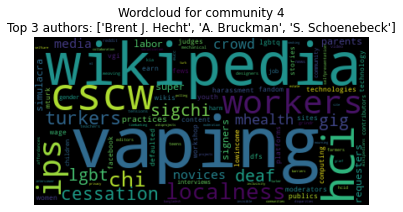

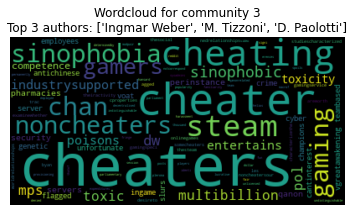

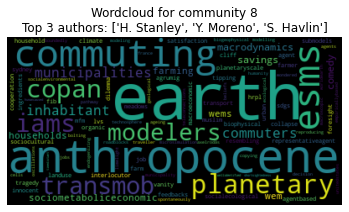

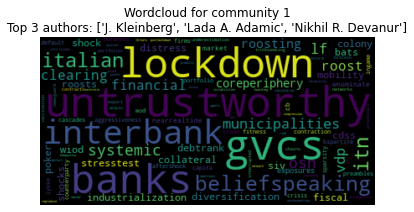

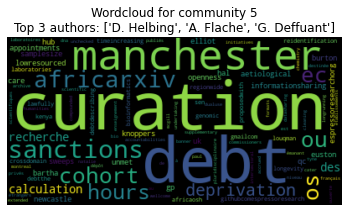

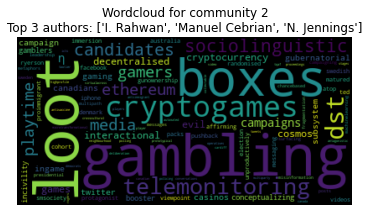

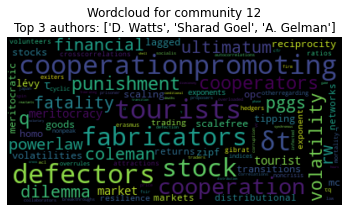

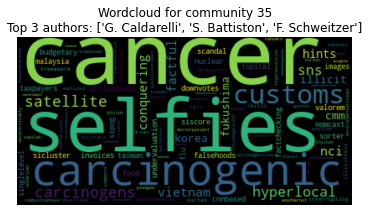

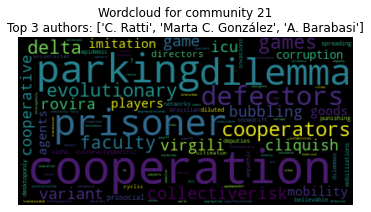

In [96]:
for community in idx_9_largest:
    plot_wordcloud(TF_IDF, community)

#### TODO COMMENT ON THE ABOVE